# Bayesian Variable Selection for Correlated Variables

#### Global Imports

In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt

from arviz import summary, plot_trace
from theano.tensor import _shared
from sklearn.preprocessing import StandardScaler

## Uncorrelated Predictors

In [2]:
sd_dist = pm.Uniform.dist(0, 1)
packed_chol = pm.LKJCholeskyCov.dist(eta=1, n=20, sd_dist=sd_dist).random()

In [3]:
chol = pm.expand_packed_triangular(20, packed_chol, lower=True).eval()

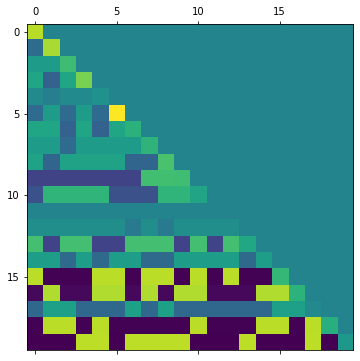

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(chol)

In [5]:
# Simulate Data
k = 20 # number of predictors
p = 5 # number of nonzero predictors
n = 5000
sigma = 0.7

np.random.seed(615)

zero_idx = np.random.choice(np.arange(0, k), k-p, replace=False)
true_beta = np.random.randn(k)
true_beta[zero_idx] = 0

In [6]:
scaler_x = StandardScaler()
# Predictor variable
X = pm.MvNormal.dist(mu=np.zeros(k), chol=chol, shape=[1, k]).random(size=n)
X = scaler_x.fit_transform(X)

In [7]:
# Simulate outcome variable
y = X.dot(true_beta) + np.random.randn(n) * sigma 

In [8]:
x = tt._shared(X)
y_obs = tt._shared(y)

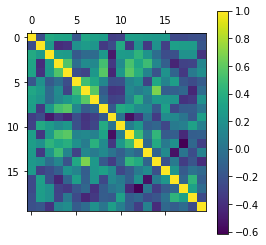

In [9]:
plt.matshow(np.cov(X.T))
plt.colorbar()

In [10]:
def GammaHyper(mean, var):
    return mean**2/var, mean/var

In [11]:
GammaHyper(0.5, 5) 

(0.05, 0.1)

In [16]:
# Linear Regression
with pm.Model() as model1:
    # Priors
    beta = pm.Normal("beta", mu=0, sigma=3, shape=k)
    sd = pm.Gamma("sd", alpha=0.05, beta=0.1, shape=1)
    
    # Likelihood
    mu = pm.Deterministic("mu", tt.dot(x, beta))
    y_ = pm.Normal("y_obs", mu=mu, sd=sd, observed=y_obs)

In [17]:
model1.check_test_point()

beta          -50.57
sd_log__       -3.17
y_obs      -29522.39
Name: Log-probability of test_point, dtype: float64

In [18]:
with model1:
    tr = pm.sample(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [02:32<00:00,  6.55it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
lines= [("beta", {"beta_dim_0":i}, true_beta[i]) for i in range(0, 20)]
fig1 = plot_trace(tr, var_names=["beta"], lines=lines)

### g-Prior - Zellner 1986 / Krishna, Bondell and Ghosh 2009

In [ ]:
print(true_beta)
summary(tr, var_names=["beta"])

In [ ]:
print(true_beta)
lines= [("beta", {"beta_dim_0":i}, true_beta[i]) for i in range(0, 20)]
fig1=plot_trace(tr, var_names=["beta"], lines=lines)

In [ ]:
g = 1/n
with pm.Model() as model2:

    # Priors
    #w = pm.Bernoulli("w", p=0.5, shape=k) 
    sd = pm.Gamma("sd", alpha=0.07, beta=0.1, shape=1, testval=0.5)
    #lam = pm.TruncatedNormal("lam", mu=0, sigma=7, lower=-1, upper=1, testval=0.99)
    F = pm.Deterministic("F", pm.math.sqr(sd)*tt.dot(tt.dot(S_, D_), St_)*n)
    kk = pm.Deterministic("k", tt.nlinalg.trace(XtX_)/tt.nlinalg.trace(F))
    beta_tilde = pm.MvNormal("beta_tilde", mu=0,  cov=kk*F, shape=k, testval=0)

    # Likelihood
    mu = pm.Deterministic("mu", tt.dot(x, beta))
    y_ = pm.Normal("y_obs", mu=mu, sd=sd, observed=y)

In [ ]:
XtX_ = X.T@X

In [ ]:
S, D, St = np.linalg.svd(XtX)

In [ ]:
XtX_lam = S@np.diag(np.power(D, 0))@St

In [ ]:
np.power(D, 0.5)

In [ ]:
kkk = np.trace(S)/np.trace(XtX_lam)

In [ ]:
S_ = _shared(S)
D_ = _shared(np.diag(np.power(D, -1))) # -1 inverse
St_ = _shared(St)
XtX_ = _shared(XtX)

In [ ]:
model2.check_test_point()

In [ ]:
with model2:
    tr = pm.sample(1000, tune=1000)

In [ ]:
print(true_beta)
lines= [("beta", {"beta_dim_0":i}, true_beta[i]) for i in range(0, 20)]
fig1 = plot_trace(tr, var_names=["beta"], lines=lines)

In [ ]:
print(true_beta)
summary(tr, var_names=["w"])

### Spike and Slab Prior - George and McCulloch 1992

In [ ]:
with pm.Model() as model2:
    # Spike and Slab Priors
    spike_prior = pm.Normal.dist(mu=0, sigma=0.01)
    slab_prior = pm.Normal.dist(mu=0, sigma=100)
    
    # w = pm.Bernoulli("w", p=0.25, shape=k) # Multinomial
    w = pm.Beta("w", alpha=0.25, beta=0.75, shape=k)
    weights = pm.Deterministic("weights", pm.math.stack([1.-w, w], axis=1))

    # Independent Normal Priors
    beta = pm.Mixture("beta", w=weights, comp_dists=[spike_prior, slab_prior], shape=k)
    sd = pm.Gamma("sd", alpha=0.05, beta=0.1)

    # Likelihood
    mu = pm.Deterministic("mu", tt.dot(x, beta))
    y_ = pm.Normal("y_", mu=mu, sd=sd, observed=y)

In [ ]:
pm.Bernoulli.dist(p=0.5, shape=6).random()

In [ ]:
model2.check_test_point()

In [ ]:
with model2:
    tr = pm.sample()

In [ ]:
print(true_beta)
summary(tr, var_names=["beta"])

In [ ]:
print(true_beta)
fig1 = plot_trace(tr, var_names=["w"])

In [ ]:
with pm.Model() as model3:
    
    # Priors
    sd = pm.Gamma("sd", alpha=0.05, beta=0.1, shape=1)
    tau = pm.HalfCauchy("tau", beta=1, shape=1) # global shrinkage
    lam = pm.HalfCauchy("lam", beta=1/s, shape=k) # local shrinkage

    scale = pm.Deterministic("scale", pm.math.sqr(lam*tau))
    beta_tilde = pm.Normal("beta_tilde", mu=0, sigma=scale, shape=k)
    beta = pm.Deterministic("beta", beta_tilde*tau*lam*sd)
    
    kappa = pm.Deterministic("kappa", 1/(1+pm.math.sqr(lam)))

    # Likelihood
    mu = pm.Deterministic("mu", tt.dot(x, beta))
    y_ = pm.Normal("y_obs", mu=mu, sd=sd, observed=y)


In [ ]:
model3.check_test_point()

In [ ]:
with model3:
    step = pm.NUTS(target_accept=0.95, max_treedepth=15, t0=15)
    tr = pm.sample(1000, tune=1000, cores=4, chains=8, step=step)

In [ ]:
summary(tr, var_names=["kappa", "beta", "sd"])

In [ ]:
fig1 = plot_trace(tr)

### Finnish Horseshoe Prior - Piironen and Vehtari 2017

In [ ]:
# Hyperparameters
m0 = p  # expected number of nonzero predictors
M = k
N = n
sigma = np.var(y)
tau0 = m0/(M-m0)*sigma/np.sqrt(N)

In [ ]:
nu = 25.
s_sq = 1

with pm.Model() as model4:
    
    # Priors
    sd = pm.Gamma("sd", alpha=0.05, beta=0.1, shape=1)
    # sd = pm.Normal("sd", mu=0.05, sd=2)

    # Hyperpriors

    tau = pm.HalfCauchy("tau", beta=tau0, shape=1) 
    c_sq = pm.InverseGamma("c_sq", alpha=nu/2, beta=nu/2*s_sq, shape=1)
    lam = pm.HalfCauchy("lam", beta=1, shape=k)     
    lam_tilde = pm.Deterministic("lam_tilde", pm.math.sqrt(c_sq)*lam/pm.math.sqrt(c_sq + pm.math.sqr(tau*lam)))

    beta_tilde = pm.Normal("beta_tilde", mu=0, sd=1, shape=k)
    beta = pm.Deterministic("beta", tau*lam_tilde*beta_tilde)
    
    # Likelihood
    mu = pm.Deterministic("mu", tt.dot(x, beta))
    y_ = pm.Normal("y_obs", mu=mu, sd=sd, observed=y)


In [ ]:
model4.check_test_point()

In [ ]:
with model4:
    tr = pm.sample(2000, tune=1000)

In [ ]:
print(true_beta)
summary(tr, var_names=["beta", "sd"])

In [ ]:
print(true_beta)
fig1 = plot_trace(tr, var_names=["beta"])

## Logistic Regression



In [ ]:
# Simulate Data
k = 20
n = 1000
sigma = 0.5

np.random.seed(615)
true_beta = np.random.randn(k)
true_beta[[2 ,3, 5, 7, 8, 9, 10, 11, 12, 13,  15, 16, 17, 19]] = 0

L = np.array(
    [[1., 0., 0., 0., 0., 0.],
    [0.5, 0.4, 0., 0., 0., 0.],
    [0.2, 0.5 , -0.7, 0., 0., 0.],
    [0., 0., 0., 1., 0., 0.],
    [0.7, 0.06, 0.03, 0., 0.8, 0.],
    [-0.7, 0., 0., 0., 0.08, .1]]
    )
K = L@L.T

# Predictor variable
#X = pm.MvNormal.dist(mu=np.zeros(6), cov=K, shape=[1, 6]).random(size=n)
X = pm.MvNormal.dist(mu=np.zeros(k), cov=np.diag(np.ones(k)), shape=[1, k]).random(size=n)
x = _shared(X)

# Simulate outcome variable
y = X.dot(true_beta) + np.random.randn(n) * sigma 


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
plt.hist(y)

In [ ]:
z = np.zeros(y.shape)

In [ ]:
z[np.where(y > 0)] = 1

In [ ]:
np.var(y)

In [ ]:
# Hyperparameters
m0 = k -2  # expected number of relevant slopes
M = k
N = n
sigma = 1/(np.mean(y)*(1-np.mean(y)))
tau0 = m0/(M-m0)*sigma/np.sqrt(N)

In [ ]:
nu = 25.
s_sq = 1

with pm.Model() as logit:
    
    # Priors
    sd = pm.Gamma("sd", alpha=0.05, beta=0.1, shape=1)
    # sd = pm.Normal("sd", mu=0.05, sd=2)

    # Hyperpriors
    tau = pm.HalfCauchy("tau", beta=tau0, shape=1) 
    c_sq = pm.InverseGamma("c_sq", alpha=nu/2, beta=nu/2*s_sq, shape=1)
    lam = pm.HalfCauchy("lam", beta=1, shape=k)     
    lam_tilde = pm.Deterministic("lam_tilde", pm.math.sqrt(c_sq)*lam/pm.math.sqrt(c_sq + pm.math.sqr(tau*lam)))

    beta_tilde = pm.Normal("beta_tilde", mu=0, sd=1, shape=k)
    beta = pm.Deterministic("beta", tau*lam_tilde*beta_tilde)
    
    # Likelihood
    mu = pm.Deterministic("mu", tt.dot(x, beta))
    p = pm.Deterministic('p', pm.math.exp(pm.Normal.dist(0, 1).logcdf(mu)))
    y_ = pm.Bernoulli('y', p=p, observed=z)


In [ ]:
logit.check_test_point()

In [ ]:
with logit:
    tr = pm.sample(2000, tune=1000)

In [ ]:
print(true_beta)

In [ ]:
summary(tr, var_names=["beta", "sd"])

In [ ]:
fig = plot_trace(tr, var_names=["beta"], )

In [ ]:
with logit:
    ppc = pm.sample_posterior_predictive(tr, samples=2000)

In [ ]:
z_pred_samps = ppc['y']
z_pred = np.zeros(z_pred_samps.shape[1])
z_probs = np.zeros([z_pred.shape[0], 2])

for i in range(0, len(y)):

    p1 = np.mean(z_pred_samps[:,i] == 0)
    p2 = np.mean(z_pred_samps[:,i] == 1)
    probs = [p1, p2]
    z_probs[i] = probs
    z_pred[i] = probs.index(max(probs))

In [ ]:
print(confusion_matrix(z, z_pred))

In [ ]:
print(f"accuracy:{round(accuracy_score(y_true=z, y_pred=z_pred),2)}")